# Google Trends for Sale Prediction - XGBoost

In this kernel, intellectual property (ex. Grand Theft Auto, Assisan's Creed, Batman, etc.) information is extracted from the item names. The main idea is that if the game or movie is popular, then the related merchandise such as toys, mugs or key chains should be popular as well. Moreover, since the dataset is real-world data, the weeks before anticipated items being sold, related keywords will be frequently searched (Google Trends). The external data from Google Trends is open and publicly accessible. Please upvote if this work is informative to you. Thanks!

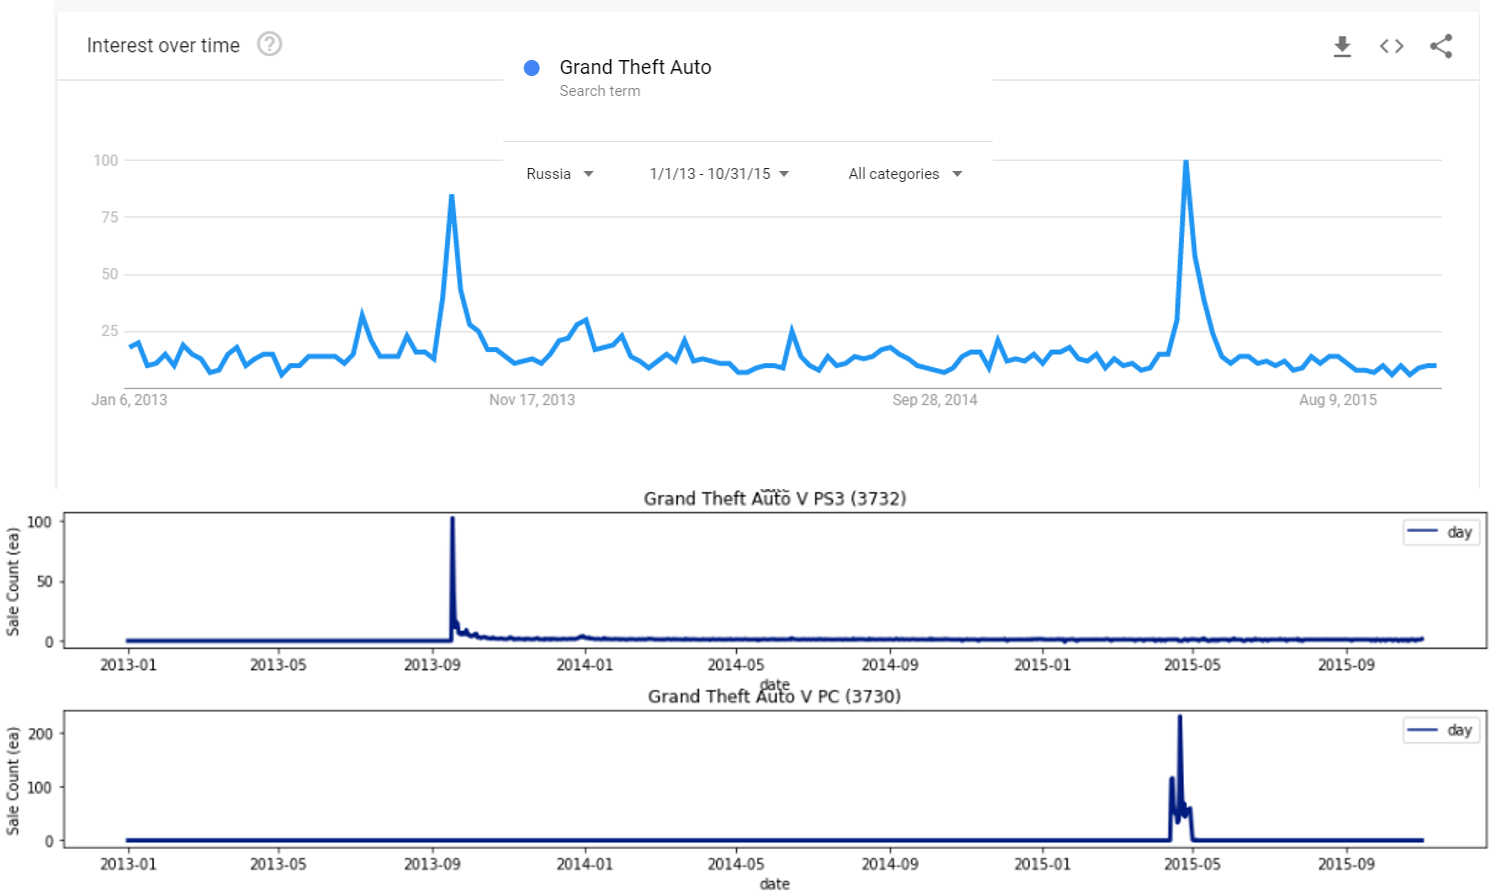

Thanks for the inspiring works and translation.
- https://www.kaggle.com/dlarionov/feature-engineering-xgboost
- https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
- https://www.kaggle.com/szhou42/predict-future-sales-top-11-solution
- https://www.kaggle.com/c/competitive-data-science-predict-future-sales/discussion/54949

## Outline

1. Setup
2. Exploratory Data Analyses
3. Data Preprocess and Base Creation
4. Feature Engineering
    - 4.1 Shop-item Pairs (Lag Features)
    - 4.2 Items (Lag Features)
    - 4.3 Item Categories (Main/Sub-Categories Extraction, Lag Features)
    - 4.4 Date (Month/Year Extraction)
    - 4.5 Shops (Shop CityExtraction, Lag Features, Shop-Item Categories Combination)
    - 4.6 Intellectual Property(IP) and Google Search Trends API
5. XGBoost Training
6. Evaluation and Submission

# 1.Setup

In [15]:
# Requirement packages
# pip install googletrans
# pip install pytrends

In [16]:
#import require modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import gc
import pickle
from sys import getsizeof
from googletrans import Translator
from pytrends.request import TrendReq

In [17]:
#variables setting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
ori_data_path = './data/'
model_path = '/'
processed_data_path = '/'
tables_path = '/'
items_IP_path = 'items_IPs_v1.csv'
items_IP_trend_path = 'items_IP_trend.csv'

In [18]:
#import datasets
df = pd.read_csv(ori_data_path+'sales_train.csv')
df_test = pd.read_csv(ori_data_path+'test.csv')
sample_submission = pd.read_csv(ori_data_path+'sample_submission.csv')
item_categories = pd.read_csv(ori_data_path+'item_categories.csv')
items = pd.read_csv(ori_data_path+'items.csv')
shops = pd.read_csv(ori_data_path+'shops.csv')

In [19]:
df[['date_block_num','shop_id']] = df[['date_block_num','shop_id']].astype('int8')
df[['item_cnt_day','item_id']] = df[['item_cnt_day','item_id']].astype('int16')
df['item_price'] = df['item_price'].astype('float32')

# 2.Exploratory Data Analyses

### Know Your Enemy
In training set, we have daily sale data from 60 shops and 21,807 kind of items (363 are new), forming 424,124 shop-itme paris. It means not all items have been sold in all shops. Here comes my first assumption. Since only when the pairs were sold at the given dates the sale data will be included, it is hard to sad the missings (zero sale count) belong to 'not introduced the that market' or 'introduced but not be sold'. Howere, we have to predict 214,400 pairs from 42 shops and 5100 kinds of items in the next month. It probabily includes a lot of zeros, and the model should be capable to predict them as well.

In [20]:
shop_test = df_test['shop_id'].nunique()
item_test = df_test['item_id'].nunique()
total_product_test = df_test[['shop_id','item_id']].drop_duplicates()
shop_train = df['shop_id'].nunique()
item_train = df['item_id'].nunique()
total_product_train = df[['shop_id','item_id']].drop_duplicates()

print('We need to predict products from {} shops and {} kinds of products (total shop-item {} pairs)'.format(shop_test,item_test,total_product_test.shape[0]))
print('given that historical daily sale number from {} shops and {} kinds of products (total shop-item {} pairs)'.format(shop_train,item_train,total_product_train.shape[0]))

We need to predict products from 42 shops and 5100 kinds of products (total shop-item 214200 pairs)
given that historical daily sale number from 60 shops and 21807 kinds of products (total shop-item 424124 pairs)


In [21]:
#100,000 pairs have no sale recored
common_pairs = total_product_test.merge(total_product_train,how='inner',on=['shop_id','item_id']).shape[0]
test_only_pairs = total_product_test.shape[0] - common_pairs
print(f'{common_pairs} pairs of products are shared by historical and to be predicted.')
print(f'{test_only_pairs} pairs are new pairs, so there is no corresponding historical data for prediciton.')

111404 pairs of products are shared by historical and to be predicted.
102796 pairs are new pairs, so there is no corresponding historical data for prediciton.


In [22]:
#363 items are new items that never seen before
total_items_test = total_product_test['item_id'].drop_duplicates()
total_items_train = total_product_train['item_id'].drop_duplicates()
total_items_join = pd.merge(total_items_test,total_items_train,how='outer',on=['item_id'],indicator=True)
total_items_join = total_items_join.replace({'both':'hisory and target','left_only':'target only','right_only':'hisory only'})
total_items_join['_merge'].value_counts()

hisory only          17070
hisory and target     4737
target only            363
Name: _merge, dtype: int64

In [23]:
del shop_test
del item_test
del total_product_test
del shop_train
del item_train
del total_product_train
del common_pairs
del test_only_pairs
del total_items_test
del total_items_train
del total_items_join
gc.collect()

53

### Monthly Trend
We can observe that for every December, the number of items sold is obviously higher than rest of the year, and overall is trending down.

Text(0.5, 1.0, 'Monthly Sale Count Trend')

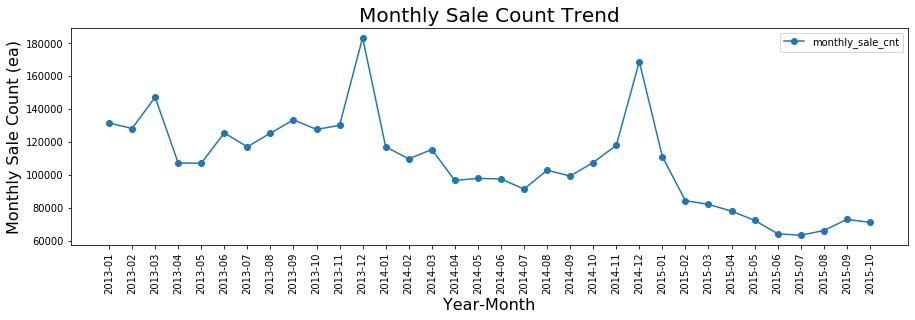

In [24]:
shop_item_pair_num_month = df
shop_item_pair_num_month['month'] = shop_item_pair_num_month['date'].apply(lambda d: d.split('.')[2] + '-' + d.split('.')[1])
shop_item_pair_num_month = df.groupby(['month','date_block_num'])['item_cnt_day'].sum()
shop_item_pair_num_month.name = 'monthly_sale_cnt'
shop_item_pair_num_month = shop_item_pair_num_month.reset_index()
ax = shop_item_pair_num_month.plot(x='month',y='monthly_sale_cnt',x_compat=True,figsize=(15,4),marker='o')

plt.xticks(shop_item_pair_num_month.date_block_num, shop_item_pair_num_month.month, rotation='vertical')

plt.xlabel('Year-Month',fontsize=16)
plt.ylabel('Monthly Sale Count (ea)',fontsize=16)
plt.title('Monthly Sale Count Trend',fontsize=20)

### Shop Monthly Sale
The white grids in the heatmap mean there are no sale records for the shops. It may be closed or haven't started for bussiness or only open for bussiness at special time or events. The heatmap combining with shop names, we can found some shops could be the same.
- 0 (! Yakutsk Ordzhonikidze, 56 Franc) -> 57 (Yakutsk Ordzhonikidze, 56)
- 1 (! Yakutsk TC "Central" Franc) -> 58 (Yakutsk TC "Central")
- 10 (Zhukovsky Street. Chkalov 39m?) -> 11 (Zhukovsky Street. Chkalov 39m)

Moreover, shop 9 and 20 are only open few times a year. I guess it could be special kind of shops, like itinerant or annual sale.

Text(0.5, 1, 'Shops Monthly Sale')

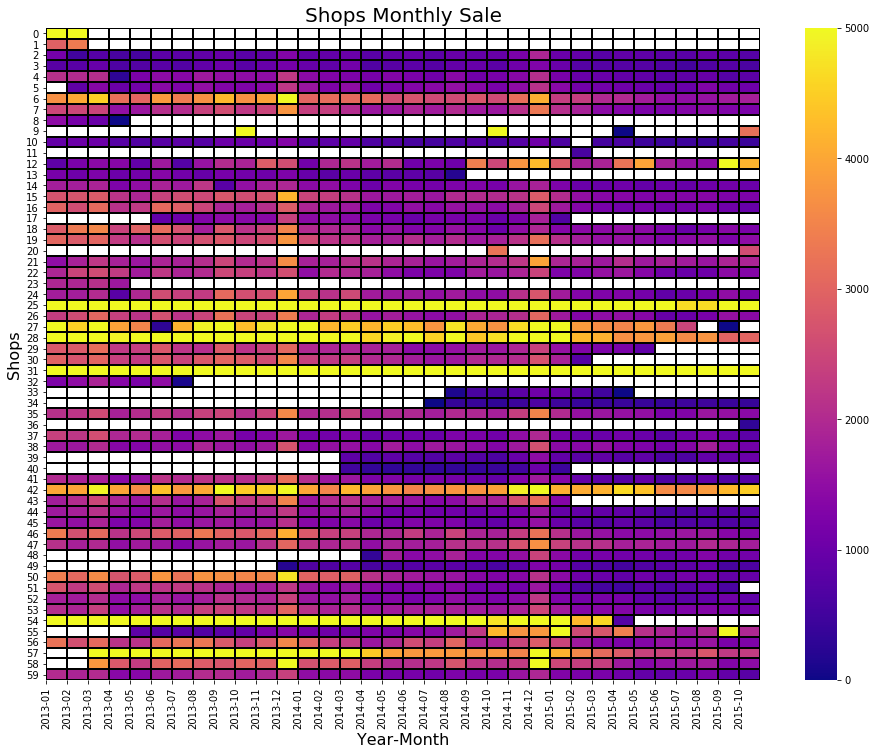

In [25]:
all_shops = np.sort(df['shop_id'].unique())
all_items = np.sort(df['item_id'].unique())
all_pairs = pd.DataFrame(index=all_shops,columns=all_items)
all_pairs = all_pairs.fillna(-1).stack()
all_pairs.index.names = ['shop_id','item_id']
all_pairs = all_pairs.reset_index()
all_pairs = all_pairs.drop(0,axis=1)

all_existed_pair_month = df.pivot_table(values='item_cnt_day', columns='date_block_num', index=['shop_id','item_id'],aggfunc='sum')

all_pairs = pd.merge(all_pairs,all_existed_pair_month,on=['shop_id','item_id'],how='left')

plt.figure(figsize=(16,12))

sns.heatmap(all_pairs.groupby('shop_id').sum().drop('item_id',axis=1).replace(0,np.nan),vmax=5000,cmap='plasma',linewidths=1,linecolor='black')
plt.xticks(shop_item_pair_num_month.date_block_num, shop_item_pair_num_month.month, rotation='vertical')

plt.xlabel('Year-Month',fontsize=16)
plt.ylabel('Shops',fontsize=16)
plt.title('Shops Monthly Sale',fontsize=20)

### Item Daily Sale Trend
Some items are stable and with continous sales almost everyday such as shopping bags, batteries or PlayStaion Network wallets. Based on previous sale records, it will be relatively easier to predict.

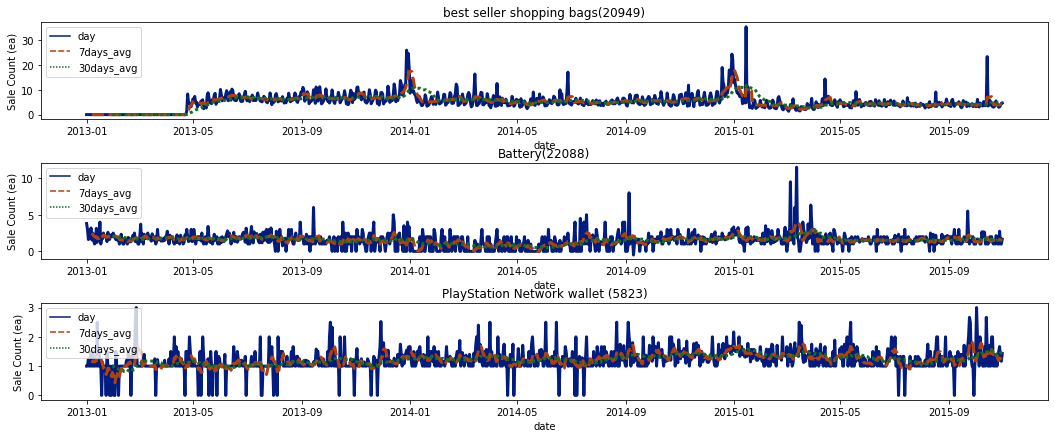

In [26]:
item_trend = df.pivot_table(index='date',columns='item_id',values='item_cnt_day',aggfunc='mean').fillna(0)
#original date format is dd.mm.yyyy
item_trend.index = item_trend.index.map(lambda d:pd.to_datetime(d.split('.')[2]+'.'+d.split('.')[1]+'.'+d.split('.')[0]))

#set multiple plots
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(311)
ax1.set(ylabel='Sale Count (ea)')
ax1.set_title('best seller shopping bags(20949)')

ax2 = fig.add_subplot(312)
ax2.set(ylabel='Sale Count (ea)')
ax2.set_title('Battery(22088)')

ax3 = fig.add_subplot(313)
ax3.set(ylabel='Sale Count (ea)')
ax3.set_title('PlayStation Network wallet (5823)')
plt.tight_layout()


#best seller shopping bags
item_1 = item_trend[20949].sort_index()
item_1 = pd.DataFrame({'day':item_1,
                         '7days_avg':item_1.rolling(window=7).mean(),
                         '30days_avg':item_1.rolling(window=30).mean()})
#Battery
item_2 = item_trend[22088].sort_index()
item_2 = pd.DataFrame({'day':item_2,
                          '7days_avg':item_2.rolling(window=7).mean(),
                          '30days_avg':item_2.rolling(window=30).mean()})
#PlayStation Network wallet
item_3 = item_trend[5823].sort_index()
item_3 = pd.DataFrame({'day':item_3,
                            '7days_avg':item_3.rolling(window=7).mean(),
                            '30days_avg':item_3.rolling(window=30).mean()})


sns.lineplot(data=item_1, palette='dark', linewidth=3, ax=ax1)
sns.lineplot(data=item_2, palette='dark', linewidth=3, ax=ax2)
sns.lineplot(data=item_3, palette='dark', linewidth=3, ax=ax3)


### Item Daily Sale Trend (conti.)
However, some items, ex. movie, anticipated games, console, tickets, etc., tend to have large number of sale in short term, and sometimes even at the month of release. It gives extra difficulty to predict, because there is no historical sale as a referece. We could use item categories and shops information to assist the predictions, but the gap still huge. My iead is to utilize the external Google Trends (search engine keyword popularity) information to assist the mission. As the figures below, the sudden sale in the dataset could be reflected on the Google Trends, but since we can't leak the future, so the nearest data I can take is the month before the target month.

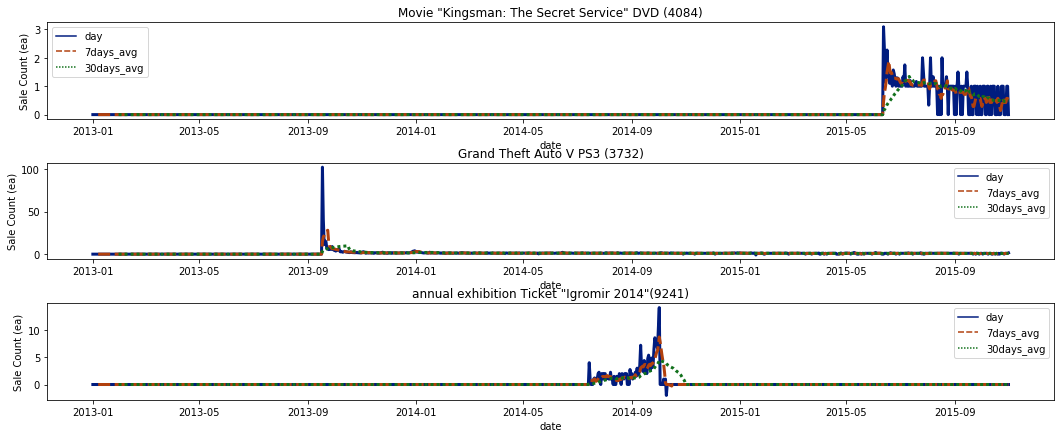

In [27]:
#set multiple plots
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(311)
ax1.set(ylabel='Sale Count (ea)')
ax1.set_title('Movie "Kingsman: The Secret Service" DVD (4084)')

ax2 = fig.add_subplot(312)
ax2.set(ylabel='Sale Count (ea)')
ax2.set_title('Grand Theft Auto V PS3 (3732)')

ax3 = fig.add_subplot(313)
ax3.set(ylabel='Sale Count (ea)')
ax3.set_title('annual exhibition Ticket "Igromir 2014"(9241)')

plt.tight_layout()


#Movie 'Kingsman' DVD , release day Jun 2015
item_1 = item_trend[4084].sort_index()
item_1 = pd.DataFrame({'day':item_1,
                         '7days_avg':item_1.rolling(window=7).mean(),
                         '30days_avg':item_1.rolling(window=30).mean()})
#Grand Theft Auto V PS3 (highest volumne at beginning), Sep 2013  Release on PS3
item_2 = item_trend[3732].sort_index()
item_2 = pd.DataFrame({'day':item_2,
                          '7days_avg':item_2.rolling(window=7).mean(),
                          '30days_avg':item_2.rolling(window=30).mean()})
#annual exhibition Ticket "Igromir 2014"  (October 3, 2014), cut off after event started
item_3 = item_trend[9241].sort_index()
item_3 = pd.DataFrame({'day':item_3,
                            '7days_avg':item_3.rolling(window=7).mean(),
                            '30days_avg':item_3.rolling(window=30).mean()})


sns.lineplot(data=item_1, palette='dark', linewidth=3, ax=ax1)
sns.lineplot(data=item_2, palette='dark', linewidth=3, ax=ax2)
sns.lineplot(data=item_3, palette='dark', linewidth=3, ax=ax3)


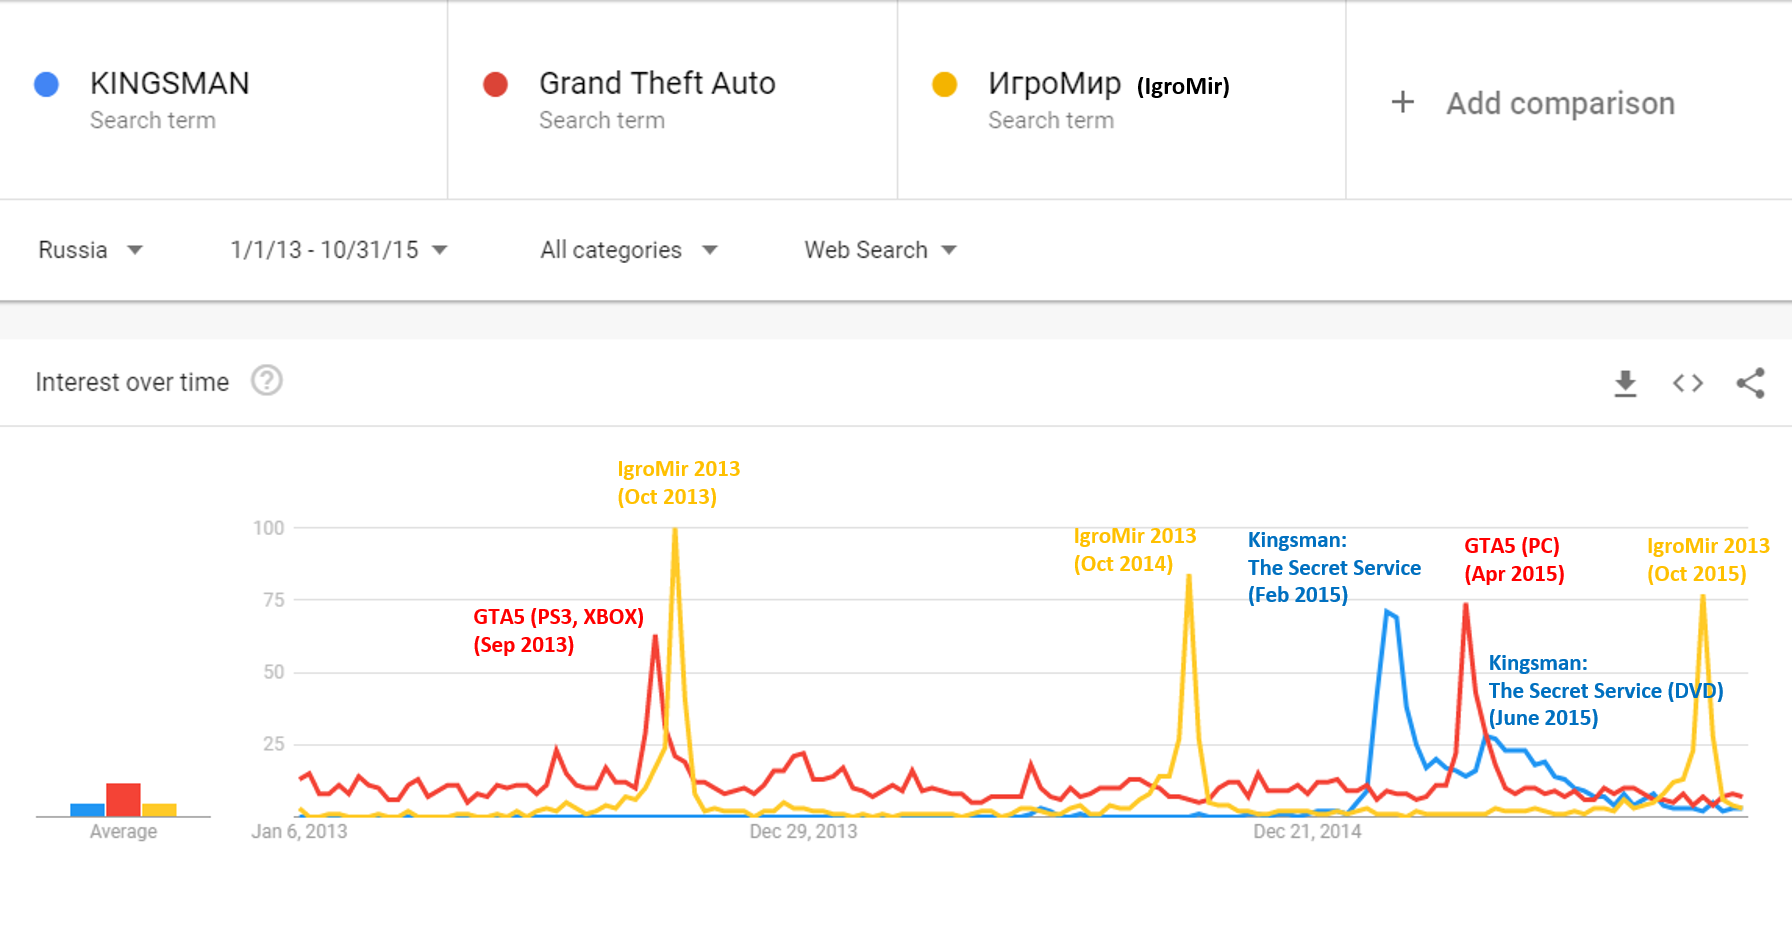

https://trends.google.com/trends/explore?date=2013-01-01%202015-10-31&geo=RU&q=KINGSMAN,Grand%20Theft%20Auto,%D0%98%D0%B3%D1%80%D0%BE%D0%9C%D0%B8%D1%80&hl=en-US

In [28]:
del shop_item_pair_num_month
del ax
del all_pairs
del all_existed_pair_month
del all_items
del all_shops
del item_trend
del item_1
del item_2
del item_3
del fig
del ax1
del ax2
del ax3
gc.collect()

129

# 3. Data Preprocess and Base Creation
In this section, the base is created. As mentioned, the test set consists of all 214,200 combinations of 42 shops and 5,100 items. Thus, to mimic the test set, the base also extends to all combinations. For examples, in month 0 ('date_block_num'=0), the sale records of 63,224 unique shop-item pairs from 45 shops and 8,115 items. However, 45 shops and 8,115 itmes can create 365,175 pairs, so the rest about 300,000 combinations will be filled by zeros.

In [29]:
%%time
for m in df['date_block_num'].unique():
    shops_list_m = np.sort(df[df['date_block_num']==m]['shop_id'].unique())
    items_list_m = np.sort(df[df['date_block_num']==m]['item_id'].unique())
    all_pairs_m = pd.DataFrame(index=shops_list_m,columns=items_list_m).fillna(m).stack()
    all_pairs_m.index.names = ['shop_id','item_id']
    all_pairs_m.name = 'date_block_num'
    
    assert len(shops_list_m) * len(items_list_m) == len(all_pairs_m)
    
    if m == 0:
        dataset = all_pairs_m
    else:
        dataset = pd.concat([dataset,all_pairs_m],axis=0)
        
    del shops_list_m
    del items_list_m
    del all_pairs_m
    gc.collect()
    
dataset = dataset.reset_index()
dataset = dataset.sort_values(by=['shop_id','item_id','date_block_num']).reset_index(drop=True)

Wall time: 57.4 s


### Merge Monthly Sale Count / Avg. Price / Montly Revenue
The test set have monthly sale clipped between 0 and 20, so apply same method to the training set. The sale count distribution is skewed, and around 95% of them are either zero or only one sold in that month.

In [30]:
cnt_month = df.groupby(['shop_id','item_id','date_block_num']).sum()['item_cnt_day']
cnt_month.name = 'item_cnt_month'

dataset = dataset.merge(cnt_month,on=['shop_id','item_id','date_block_num'],how='left')
dataset['item_cnt_month'] = dataset['item_cnt_month'].fillna(0).clip(0,20)

del cnt_month
gc.collect()

20

In [31]:
price_pivot_month = df.pivot_table(values='item_price', columns='date_block_num', index=['shop_id','item_id'])

price_pivot_month = price_pivot_month.fillna(method='ffill',axis=1)
price_pivot_month = price_pivot_month.fillna(0)

#transform from wide to long format
price_pivot_month = price_pivot_month.stack()
price_pivot_month.name = 'avg_price'
price_pivot_month = price_pivot_month.reset_index()

#clip price to 0~50000 to prevent outliers
price_pivot_month['avg_price'] = price_pivot_month['avg_price'].clip(0,50000)

#merge back to main table
dataset = dataset.merge(price_pivot_month,on=['shop_id','item_id','date_block_num'],how='left').fillna(0)
dataset['revenue']=dataset['avg_price']*dataset['item_cnt_month']

del price_pivot_month
gc.collect()

0

### Merge Test Data

In [32]:
df_test['date_block_num'] = 34
dataset = pd.concat([dataset,df_test.drop('ID',axis=1)],axis=0).reset_index(drop=True)

assert dataset.isnull().sum().max() == len(df_test)

dataset = dataset.fillna(0) #only for test data

In [33]:
#compress DataFrame for lower memory usage
float32_cols = ['revenue','avg_price']
int16_cols =['item_id']
int8_cols = ['date_block_num','shop_id','item_cnt_month']

dataset[int8_cols] = dataset[int8_cols].astype('int8')
dataset[int16_cols] = dataset[int16_cols].astype('int16')
dataset[float32_cols] = dataset[float32_cols].astype('float32')

# 4. Feature Engineering

### Re-usable Functions

In [34]:
def add_lag_v3(dataset,lookup_set,lag_months,lag_features_list,on_key,fillna_value,dtypes):
    
    """
    Function to create one of multiple lagged features
    
    Parameters: 
    ------------
    dataset : (pd.DataFrame) target dataset 
    
    look_set :(pd.DataFrame)  source of features. Need to be groupped by desired key such as shop_id, item_category_id, or 
        other customized group. create_mean_encoding_table() is created for this. 'None' means using the target dataset. 
    
    lag_months : (list) list of lagged features, ex. [1,2,3] means adding 3 columns with lagged 1,2 and 3
    
    lag_features_list : (list) list of targeted features' name, should be existing in the lookup_set
    
    on_key : (list) list of keys used to merge the dataset and lookup_set
    
    fillna_value : (list) how to fill missing for each of lagged features in the lag_features_list.
    
    dtypes : (list) dtypes of generated lagged featrures. Note 'fillna_value' and 'dtypese' are addtional properties of 
        'lag_features_list', so it is necessery to be in the same order and length. 
    ------------
    """
    if lookup_set is None:
        lookup_set = dataset[on_key + lag_features_list].copy()
    else:    
        dataset = pd.merge(dataset,lookup_set,how='left',on=on_key)
    
    #breakpoint()
    
    
    # create lagged features for each month
    for lag in lag_months:
        dataset_alignment = dataset[on_key + lag_features_list].copy() #small subset for alignment to reduce memory usage
        dataset_lag = lookup_set[on_key + lag_features_list]
        dataset_lag['date_block_num'] = dataset_lag['date_block_num'] + lag
        dataset_alignment = pd.merge(dataset_alignment,dataset_lag,how='left',on=on_key,suffixes=['','_lag_'+str(lag)+'m'])
        dataset_alignment = dataset_alignment.drop(on_key + lag_features_list,axis=1)
        #breakpoint()
        dataset = pd.concat([dataset,dataset_alignment],axis=1,join='outer')
        del dataset_lag
        del dataset_alignment
        gc.collect()
    
    # dtypes setting
    for i,feature in enumerate(lag_features_list):
        new_columns = dataset.columns.str.startswith(feature + '_lag_')
        dataset.loc[:,new_columns] = dataset.loc[:,new_columns].fillna(fillna_value[i]).astype(dtypes[i])
        
    return dataset

In [35]:
def add_first_last_sale(dataset,source_set,keys,prefix):
    """
    Search the month of first sale and last sale, only read historical data, 
    ex. for month 8, only month 0~7 will be used to judge.
    Then, it creates both relative and absolut values. 
    ex. at month 8, the absolute last month is 7, and then the relative will be -1
    
    Parameters: 
    ------------
    dataset : (pd.DataFrame) target dataset 
    
    source_set :(pd.DataFrame) source dataframe to judge first/last
    
    keys : (list) level of group. ex. ['shop_id','item_id'] means judging by shop-item pair 
    
    prefix : (str) prefix of created columns
    ------------
    """    
    for m in range(1,35): #1~34m
    
        #only use historical data to judge (0 to m-1)
        tmp = source_set[source_set['date_block_num']<m].drop_duplicates(keys+['date_block_num']).groupby(keys).agg({'date_block_num':[np.min,np.max]})
        tmp.columns = [prefix + '_first_sold', prefix + '_last_sold']
        tmp = tmp.reset_index()
        tmp['date_block_num'] = m 
        
        if m == 1:  
            first_last_sold = tmp
        else:
            first_last_sold = pd.concat([first_last_sold,tmp],axis=0)
            
        del tmp
        gc.collect()
    #breakpoint()
        
    dataset = dataset.merge(first_last_sold,on=keys+['date_block_num'],how='left')
        
    dataset[prefix + '_first_sold_offset'] = dataset[prefix + '_first_sold'] - dataset['date_block_num']
    dataset[prefix + '_last_sold_offset'] = dataset[prefix + '_last_sold'] - dataset['date_block_num']
    
    columns = [prefix + '_first_sold', prefix + '_last_sold',prefix + '_first_sold_offset', prefix + '_last_sold_offset']
    dataset[columns] = dataset[columns].fillna(0)
    dataset[columns] = dataset[columns].astype('int8')
    
    return dataset

In [36]:
def price_diff(row,columnA,columnB):
        #compare columnA price with columnB ((A-B)/B) in percentage
        if row[columnB] == 0:
            increase_percent = 0
        else:    
            increase_percent = round((row[columnA]-row[columnB])/row[columnB]*100)
        return increase_percent

In [37]:
def create_mean_encoding_table(dataset:pd.DataFrame, encode_item:list, prefix:str):
    #breakpoint()
    encoding_table = dataset[encode_item +['date_block_num','item_cnt_month','revenue','avg_price']] #remove 0 to reduce bias
    encoding_table.loc[:,['item_cnt_month','revenue','avg_price']] = encoding_table.loc[:,['item_cnt_month','revenue','avg_price']].replace(0,np.nan)
    encoding_table = encoding_table.groupby(encode_item + ['date_block_num']).agg({'item_cnt_month':[np.mean],'revenue':[np.mean],'avg_price':[np.mean]})
    encoding_table = encoding_table.fillna(0)
    encoding_table.columns = [prefix+'_avg_cnt_month', prefix+'_avg_revenue_month',prefix+'_avg_price_month']
    encoding_table = encoding_table.reset_index()
    
    encoding_table[['date_block_num',prefix+'_avg_cnt_month']] = encoding_table[['date_block_num',prefix+'_avg_cnt_month']].astype('float16')
    encoding_table[encode_item] = encoding_table[encode_item].astype('int16')
    encoding_table[[prefix+'_avg_revenue_month',prefix+'_avg_price_month']] = encoding_table[[prefix+'_avg_revenue_month',prefix+'_avg_price_month']].astype('float32')
    
    return encoding_table

In [38]:
def first_sale_cnt(dataset,source_set,keys,prefix,forward_range=6):
    """
    function to calculate avg. first sale count
    
    Parameters: 
    ------------
    dataset : (pd.DataFrame) target dataset 
    
    source_set :(pd.DataFrame) source dataframe to judge first/last and avg. sale count
    
    keys : (list) level of group. ex. ['shop_id','item_id'] means judging by shop-item pair 
    
    prefix : (str) prefix of created columns
    
    forward_range : (int) include how many months data to calculate. It may have large variage by judging only one month, 
        because their would be only few items are been sold for the fisrt time in the last month
    ------------
    """    
    #filter unnecessary data (not first sale, extra columns)
    source_set = source_set[keys+['date_block_num','item_first_sold_offset','item_cnt_month']]
    source_set = source_set[source_set['item_first_sold_offset']==0]
    source_set = source_set.drop('item_first_sold_offset',axis=1)
    source_set = source_set[source_set['item_cnt_month']>0] #extra zeros are padded to simulate test set
    
    for m in range(1,35): #1~34m      
        
        #take previous 6 months data to prevent large variation
        tmp = source_set[source_set['date_block_num'].between(m-1-6,m-1)].groupby(keys).agg({'item_cnt_month':[np.mean]})
        tmp.columns = [prefix + '_avg_first_sold_cnt_month']
        tmp = tmp.reset_index()
        tmp['date_block_num'] = m #(m-1-6 to m-1)data is for month m
        
        if m == 1:  
            avg_first_sold_cnt = tmp
        else:
            avg_first_sold_cnt = pd.concat([avg_first_sold_cnt,tmp],axis=0)
            
        del tmp
        #breakpoint()
        
    dataset = dataset.merge(avg_first_sold_cnt,on=keys+['date_block_num'],how='left')
        
    columns = [prefix + '_avg_first_sold_cnt_month']
    dataset[columns] = dataset[columns].fillna(0)
    dataset[columns] = dataset[columns].astype('float16')
    
    return dataset

In [39]:
def get_google_trends(IPs, file_path, reference):
    """
    function to access Google Trends to fetch search popularity trend for each keywords
    
    Parameters: 
    ------------
    IPs : (list) list of keywords need to be searched
    
    file_path :(str) path to save/load Google Trend data since API has a usage limit
    
    reference : (str) a reference keyword to make Google Trend data can be compared across different keywords 
    ------------
    """    
    
    pytrend = TrendReq(hl='ru', tz=360)
    
    try:
        IP_trend = pd.read_csv(file_path)
        existed_columns = IP_trend.columns
    except FileNotFoundError:
        IP_trend = None
        existed_columns = []
    #breakpoint()  
    for IP in IPs:
        if IP in existed_columns:
            continue
        
        #every trend is normalized to itself, so a general reference will make it comparable with others
        if IP == reference:
            keywords = [reference]
        else:
            keywords = [IP,reference]
        pytrend.build_payload(kw_list=keywords,cat=0,timeframe='2013-01-01 2015-10-31',geo='RU',gprop='')

        trend_df = pytrend.interest_over_time()
        trend_df = trend_df.drop(reference,axis=1)
        if len(trend_df) == 0:
            #no key word trends found
            if IP_trend is not None:
                IP_trend[IP] = 0
        else:    
            trend_df = trend_df.reset_index()

            trend_df['year'] = trend_df['date'].dt.year
            trend_df['month'] = trend_df['date'].dt.month

            trend_df = trend_df.drop(['date','isPartial'],axis=1)
            trend_df = trend_df.groupby(['year','month']).max().reset_index()

            if IP_trend is None:
                IP_trend = trend_df
            else:       
                IP_trend = IP_trend.merge(trend_df,on=['year','month'],how='left')

# cannot override the file system on kaggle
#     IP_trend.to_csv(file_path, index=False)
    return IP_trend

## 4.1 Shop-item Pairs
- Add pair sale count lagged features
- Add pair price lagged features
- Add pair fisrt/last time being sold, both absolute monthes and relative monthes (only the data before each month can be used)

In [40]:
%%time
lag_months = [1,2,3,6,12]
lag_features_list = ['item_cnt_month']
on_key = ['shop_id','item_id','date_block_num']
fillna = [0]
dtypes = ['int8']

dataset = add_lag_v3(dataset,None,lag_months,lag_features_list,on_key,fillna,dtypes)

Wall time: 41.9 s


In [41]:
%%time
lag_months = [1]
lag_features_list = ['avg_price']
on_key = ['shop_id','item_id','date_block_num']
fillna = [0]
dtypes = ['float32']

dataset = add_lag_v3(dataset,None,lag_months,lag_features_list,on_key,fillna,dtypes)

Wall time: 8.47 s


In [42]:
#add lag first sale month and last sale mont
dataset = add_first_last_sale(dataset,df,['shop_id','item_id'],'pair')
dataset = dataset.drop(['pair_first_sold','pair_last_sold'],axis=1)

## 4.2 Items
- Add item avg. sale count / revenue / price lagged features
- Add item fisrt/last time being sold, both absolute monthes and relative monthes

In [43]:
%%time
item_month_sale = create_mean_encoding_table(dataset, ['item_id'], 'item')

lag_months = [1]
lag_features_list = ['item_avg_cnt_month', 'item_avg_revenue_month', 'item_avg_price_month']
on_key = ['item_id','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,item_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)

dataset = dataset.drop(['item_avg_cnt_month','item_avg_revenue_month', 'item_avg_price_month'],axis=1)
del item_month_sale
gc.collect()

C:\Users\Monster\anaconda3\envs\ds_env\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Wall time: 13.8 s


9

In [44]:
%%time
#add lag first sale month and last sale mont
dataset = add_first_last_sale(dataset,df,['item_id'],'item')
dataset = dataset.drop(['item_first_sold','item_last_sold'],axis=1)

Wall time: 19 s


## 4.3 Item Categories
- Add item_category_id to main dataset
- Translate item_category_name and create main- and sub-categories. Original names are in format 'MainGroup-SubGroup'
- Add 3 categories (item_category , main-, sub-category) avg. sale count / revenue / price lagged features

In [45]:
#merge item_category id into main dataset
dataset = pd.merge(dataset,items[['item_id','item_category_id']],how='left',on=['item_id'])
dataset['item_category_id'] = dataset['item_category_id'].astype('int16')

In [46]:
#google API has daily usage limit, try to read file first
try:
    item_categories_plus = pd.read_csv(tables_path + 'item_categories_plus.csv')
except FileNotFoundError:
    item_categories_plus = item_categories.copy()
    #translation
    trans = Translator()
    item_categories_plus['item_category_name_en'] = item_categories_plus['item_category_name'].apply(lambda name: trans.translate(name,dest='en').text)
    item_categories_plus
    item_categories_plus.to_csv(tables_path + 'item_categories_plus.csv')
    
#roughly grouping first
item_categories_plus['main_category'] = item_categories_plus['item_category_name_en'].apply(lambda name: name.split('-')[0].strip())
item_categories_plus['sub_category'] = item_categories_plus['item_category_name_en'].apply(
    lambda name: (name.split('-')[1].strip()) if len(name.split('-'))>1 else (name.split('-')[0].strip()))

#manually correct grouping
item_categories_plus.loc[24,'main_category'] = 'Games' #translation failed
item_categories_plus.loc[71,'main_category'] = 'Platic Bags and Gift' #plastic bag outlier -> stand alone group
item_categories_plus.loc[78,'main_category'] = 'Program' #programs -> program
item_categories_plus.loc[32,'main_category'] = 'Payment cards' #Payment card (Movies, Music, Games) -> Payment cards, and (Movies, Music, Games)
item_categories_plus.loc[32,'sub_category'] = '(Movies, Music, Games)' #Payment card  -> Payment cards
item_categories_plus.loc[36,'main_category'] = 'Payment cards'
item_categories_plus.loc[37:41,'main_category'] = 'Movies' #correct Movie, Movies, Cinema two groups

#label encoding
main_category_encoder = LabelEncoder()
item_categories_plus['main_category_enc'] = main_category_encoder.fit_transform(item_categories_plus['main_category']).astype('int8')
sub_category_encoder = LabelEncoder()
item_categories_plus['sub_category_enc'] = sub_category_encoder.fit_transform(item_categories_plus['sub_category']).astype('int8')

dataset = pd.merge(dataset,item_categories_plus[['item_category_id','main_category_enc','sub_category_enc']],how='left',on=['item_category_id'])

del item_categories_plus
gc.collect()

0

In [47]:
# %%time
# cate_month_sale = create_mean_encoding_table(dataset, ['item_category_id'], 'cate')

# lag_months = [1]
# lag_features_list = ['cate_avg_cnt_month', 'cate_avg_revenue_month', 'cate_avg_price_month']
# on_key = ['item_category_id','date_block_num']
# fillna = [0,0,0]
# dtypes = ['float16','float32','float32']

# dataset = add_lag_v3(dataset,cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
# dataset = dataset.drop(['cate_avg_cnt_month', 'cate_avg_revenue_month','cate_avg_price_month'],axis=1)

# del cate_month_sale
# gc.collect()

In [48]:
%%time
main_cate_month_sale = create_mean_encoding_table(dataset, ['main_category_enc'], 'main_cate')

lag_months = [1]
lag_features_list = ['main_cate_avg_cnt_month', 'main_cate_avg_revenue_month', 'main_cate_avg_price_month']
on_key = ['main_category_enc','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,main_cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['main_cate_avg_cnt_month','main_cate_avg_revenue_month', 'main_cate_avg_price_month'],axis=1)

del main_cate_month_sale
gc.collect()

Wall time: 16.5 s


9

In [49]:
%%time
sub_cate_month_sale = create_mean_encoding_table(dataset, ['sub_category_enc'], 'sub_cate')

lag_months = [1]
lag_features_list = ['sub_cate_avg_cnt_month', 'sub_cate_avg_revenue_month', 'sub_cate_avg_price_month']
on_key = ['sub_category_enc','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,sub_cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['sub_cate_avg_cnt_month','sub_cate_avg_revenue_month', 'sub_cate_avg_price_month'],axis=1)

del sub_cate_month_sale
gc.collect()

Wall time: 17.2 s


9

In [50]:
%%time
#add first sold information for categories
dataset = first_sale_cnt(dataset,dataset,['item_category_id'],'cate')
dataset = first_sale_cnt(dataset,dataset,['main_category_enc'],'main_cate')
dataset = first_sale_cnt(dataset,dataset,['sub_category_enc'],'sub_cate')

Wall time: 30.9 s


## 4.4 Date
- Extract Year/Month information from date

In [51]:
#parse year/month information from 'date'
date_features = df.drop_duplicates(['date_block_num'])[['date','date_block_num']]
date_features['year'] = date_features['date'].apply(lambda d: d.split('.')[2])
date_features['month'] = date_features['date'].apply(lambda d: d.split('.')[1])
date_features = date_features.drop('date',axis=1).reset_index(drop=True)

#fill year/month information for test data
test_date = [34,2015,11]
date_features.loc[34] = test_date

#merge into main dataset
dataset = pd.merge(dataset,date_features,how='left',on=['date_block_num'])

#compress and delete temporary dataset to release memory
dataset[['month','year']] = dataset[['month','year']].astype('int16')

#keep date_features for later usage

## 4.5 Shops
- Merge shops
- Add City of shops, but shome of them are special seperate from city, 
    like no.9 is itinerant, no.12 is online emergency,no.20 is only open once a year, and no.55 is online shop
- Add first/last month the shops have sale record (absolute and relative)
- Add Shop/City avg. sale count / revenue / price lagged features
- Add Shop-Item Category avg. sale count / revenue / price lagged features

In [52]:
dataset['shop_id'] = dataset['shop_id'].replace({0:57,1:58,10:11})
df['shop_id'] = df['shop_id'].replace({0:57,1:58,10:11})

In [53]:
try:
    shops_plus = pd.read_csv(tables_path + 'shops_plus.csv')
except FileNotFoundError:
    shops_plus = shops.copy()
    trans = Translator()
    shops_plus['shop_name_en'] = shops_plus['shop_name'].apply(lambda name: trans.translate(name,dest='en').text)
    shops_plus.to_csv(tables_path + 'shops_plus.csv')

#extract city
shops_plus['shop_city'] = shops_plus['shop_name_en'].apply(lambda shop: shop.split(' ')[0].strip())

#manually correct
shops_plus.loc[0:1,'shop_city'] = 'Yakutsk' #correct name
shops_plus.loc[12,'shop_city'] = 'Online_emergency' #online emergency shop
shops_plus.loc[20,'shop_city'] = 'Sale' #seperate from Moscow
shops_plus.loc[42:43,'shop_city'] = 'St.Petersburg' #correct name

#encode
shop_enc = LabelEncoder()
shops_plus['shop_city_enc'] = shop_enc.fit_transform(shops_plus['shop_city'])
shops_plus['shop_city_enc'] = shops_plus['shop_city_enc'].astype('int8')

#merge city index into main table
dataset = dataset.merge(shops_plus[['shop_id','shop_city_enc']],how='left',on=['shop_id'])
del shops_plus
gc.collect()

0

In [54]:
#add lag first sale month and last sale mont
dataset = add_first_last_sale(dataset,df,['shop_id'],'shop')
dataset = dataset.drop(['shop_first_sold','shop_last_sold'],axis=1)

In [55]:
%%time
shop_month_sale = create_mean_encoding_table(dataset, ['shop_id'], 'shop')

lag_months = [1,2,3,6,12]
lag_features_list = ['shop_avg_cnt_month', 'shop_avg_revenue_month', 'shop_avg_price_month']
on_key = ['shop_id','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,shop_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['shop_avg_cnt_month', 'shop_avg_revenue_month','shop_avg_price_month'],axis=1)

del shop_month_sale
gc.collect()

Wall time: 45.7 s


9

In [56]:
%%time
shop_city_month_sale = create_mean_encoding_table(dataset, ['shop_city_enc'], 'shop_city')

lag_months = [1]
lag_features_list = ['shop_city_avg_cnt_month', 'shop_city_avg_revenue_month', 'shop_city_avg_price_month']
on_key = ['shop_city_enc','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,shop_city_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['shop_city_avg_cnt_month','shop_city_avg_revenue_month','shop_city_avg_price_month'],axis=1)

del shop_city_month_sale
gc.collect()

Wall time: 32 s


9

In [57]:
# %%time
# shop_cate_month_sale = create_mean_encoding_table(dataset, ['shop_id','item_category_id'], 'shop_cate')

# lag_months = [1,2,3,6,12]
# lag_features_list = ['shop_cate_avg_cnt_month', 'shop_cate_avg_revenue_month', 'shop_cate_avg_price_month']
# on_key = ['shop_id','item_category_id','date_block_num']
# fillna = [0,0,0]
# dtypes = ['float16','float32','float32']

# dataset = add_lag_v3(dataset,shop_cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
# dataset = dataset.drop(['shop_cate_avg_revenue_month','shop_cate_avg_revenue_month','shop_cate_avg_price_month'],axis=1)

# del shop_cate_month_sale
# gc.collect()

In [58]:
%%time
shop_main_cate_month_sale = create_mean_encoding_table(dataset, ['shop_id','main_category_enc'], 'shop_main_cate')

lag_months = [1]
lag_features_list = ['shop_main_cate_avg_cnt_month', 'shop_main_cate_avg_revenue_month', 'shop_main_cate_avg_price_month']
on_key = ['shop_id','main_category_enc','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,shop_main_cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['shop_main_cate_avg_cnt_month','shop_main_cate_avg_revenue_month','shop_main_cate_avg_price_month'],axis=1)

del shop_main_cate_month_sale
gc.collect()

Wall time: 35.5 s


9

In [59]:
%%time
shop_sub_cate_month_sale = create_mean_encoding_table(dataset, ['shop_id','sub_category_enc'], 'shop_sub_cate')

lag_months = [1,2,3,6,12]
lag_features_list = ['shop_sub_cate_avg_cnt_month', 'shop_sub_cate_avg_revenue_month', 'shop_sub_cate_avg_price_month']
on_key = ['shop_id','sub_category_enc','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,shop_sub_cate_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['shop_sub_cate_avg_cnt_month','shop_sub_cate_avg_revenue_month','shop_sub_cate_avg_price_month'],axis=1)

del shop_sub_cate_month_sale
gc.collect()

Wall time: 1min 11s


9

## 4.6 Intellectual Property (IP) and Google Search Trends API
The iead of this part is that if some Intellectual Properties (IPs) like The Witcher, Minecraft, Spider Man, Star Wars etc. are popular right now, not just the games or movies themselves, their related merchandise such as key chains or mugs will have a higher sell than others.

Moreover, the model heavily relies on historical sale data, so for new prodcuts, especially those with a very high sale count, are hard to predict. Google Search Trends provides a local keywords search popularity with respect to time, and thus we can utilize the popularity information before the start of selling. For example, a new movie or game or game console is about to release to market, more people getting interesting in, more of them are to search for information.

- Use Pytrends API to get Google Trends infomation
- Add IP/Google Trends avg. sale count / revenue / price lagged features

In [60]:
%%time
#extra table item_id - IPs (names or titles or certain series of games, movies, characters)
item_IP = pd.read_csv(items_IP_path) #manually groupped table
IP_label = LabelEncoder()
item_IP['IP_encode'] = IP_label.fit_transform(item_IP['Search_Key_Word'])
dataset = dataset.merge(item_IP[['item_id','IP_encode']],on='item_id',how='left')
dataset['IP_encode'] = dataset['IP_encode'].astype('int16')

#google trends API to get trends, (will not override existed data)
IPs = list(item_IP['Search_Key_Word'].unique())
IPs.remove('Others')
IP_trend = get_google_trends(IPs, items_IP_trend_path,'Total War') #collect google trends info by IP keywords

#reshape to long format from wide to be able to merge
date_features[['year','month']] = date_features[['year','month']].astype('int64')
IP_trend = IP_trend.merge(date_features,on=['year','month'],how='left')
IP_trend = IP_trend.drop(['month','year'],axis=1)
IP_trend = IP_trend.set_index('date_block_num').stack().reset_index()
IP_trend.columns = ['date_block_num','Search_Key_Word','google_trends']

#lookup IP_encode (this way allow csv to save old key words and their trends)
IP_trend = IP_trend.merge(item_IP[['Search_Key_Word','IP_encode']].drop_duplicates(),on='Search_Key_Word',how='left')
IP_trend = IP_trend.dropna()
IP_trend = IP_trend.sort_values(by=['IP_encode','date_block_num'])

Wall time: 43 s


In [61]:
%%time
lag_months = [1,2,3,6,12]
lag_features_list = ['google_trends']
on_key = ['IP_encode','date_block_num']
fillna = [0]
dtypes = ['int8']

dataset = add_lag_v3(dataset,IP_trend,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['Search_Key_Word','google_trends'],axis=1)
del IP_trend
gc.collect()

<ipython-input-34-826b13d0d3c0>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_lag['date_block_num'] = dataset_lag['date_block_num'] + lag


Wall time: 52.8 s


9

In [62]:
%%time
IP_month_sale = create_mean_encoding_table(dataset, ['IP_encode'], 'IP')

lag_months = [1]
lag_features_list = ['IP_avg_cnt_month', 'IP_avg_revenue_month', 'IP_avg_price_month']
on_key = ['IP_encode','date_block_num']
fillna = [0,0,0]
dtypes = ['float16','float32','float32']

dataset = add_lag_v3(dataset,IP_month_sale,lag_months,lag_features_list,on_key,fillna,dtypes)
dataset = dataset.drop(['IP_avg_cnt_month', 'IP_avg_revenue_month','IP_avg_price_month'],axis=1)
del IP_month_sale
gc.collect()

Wall time: 1min


9

### Finshing
clear temporary variables, check if missing/infinite existed, save dataset for latter usage

In [63]:
del IPs
del item_IP
del date_features

del lag_months
del lag_features_list
del on_key
del fillna
del dtypes

del IP_label
del LabelEncoder

del df
del df_test
del sample_submission
del items
del shops
gc.collect()

20

In [64]:
assert dataset.isnull().sum().sum() == 0
assert np.isfinite(dataset).sum().sum() == dataset.shape[0] * dataset.shape[1]

dataset = dataset.drop(['avg_price','revenue'],axis=1)

dataset.to_pickle(processed_data_path + 'dataset.pkl')

# del dataset
# gc.collect()

# 5. XGBoost Training
Extreme Gradient Boost (XGBoost) is a powerful optimized decision tree-based grident boost algorithm, and it is possible to accelerate by GPU. Grident boost uses large numbers of relative small and weak decision trees to model the residues for each iteration. In each iteration, it gives a 'direction', then update the predictions and residues until stop criteria are reached.

- Load Dataset and Setting
- Model Hyperparameter Tuning and Training

### Load Dataset and Setting
The structure allows the pre-processing procedure separated with the training procedure.

In [65]:
dataset = pd.read_pickle(processed_data_path + 'dataset.pkl')

In [66]:
dataset.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'item_cnt_month_lag_1m', 'item_cnt_month_lag_2m',
       'item_cnt_month_lag_3m', 'item_cnt_month_lag_6m',
       'item_cnt_month_lag_12m', 'avg_price_lag_1m', 'pair_first_sold_offset',
       'pair_last_sold_offset', 'item_avg_cnt_month_lag_1m',
       'item_avg_revenue_month_lag_1m', 'item_avg_price_month_lag_1m',
       'item_first_sold_offset', 'item_last_sold_offset', 'item_category_id',
       'main_category_enc', 'sub_category_enc',
       'main_cate_avg_cnt_month_lag_1m', 'main_cate_avg_revenue_month_lag_1m',
       'main_cate_avg_price_month_lag_1m', 'sub_cate_avg_cnt_month_lag_1m',
       'sub_cate_avg_revenue_month_lag_1m', 'sub_cate_avg_price_month_lag_1m',
       'cate_avg_first_sold_cnt_month', 'main_cate_avg_first_sold_cnt_month',
       'sub_cate_avg_first_sold_cnt_month', 'year', 'month', 'shop_city_enc',
       'shop_first_sold_offset', 'shop_last_sold_offset',
       'shop_avg_cnt_month_lag_1m', 

In [67]:
#feature selection
selected = [
    'item_cnt_month', #must (target)
    'date_block_num', #must (to split training/validation/testing, will be omitted later)
    
    #pairs-related
    'item_cnt_month_lag_1m','item_cnt_month_lag_2m','item_cnt_month_lag_3m',
    'item_cnt_month_lag_6m','item_cnt_month_lag_12m','pair_first_sold_offset',
    
    #items-related
    'item_avg_cnt_month_lag_1m','item_first_sold_offset',
    
    #item categories-related
    'main_cate_avg_cnt_month_lag_1m','main_cate_avg_revenue_month_lag_1m',
    'sub_cate_avg_revenue_month_lag_1m','sub_cate_avg_cnt_month_lag_1m',    
    'cate_avg_first_sold_cnt_month','main_cate_avg_first_sold_cnt_month','sub_cate_avg_first_sold_cnt_month',
    
    #date
    'month',
    
    #shops-related
    'shop_avg_cnt_month_lag_1m','shop_avg_cnt_month_lag_2m','shop_avg_cnt_month_lag_3m',
    'shop_avg_cnt_month_lag_6m','shop_avg_cnt_month_lag_12m','shop_city_avg_cnt_month_lag_1m',
    'shop_first_sold_offset','shop_last_sold_offset',
    'shop_main_cate_avg_cnt_month_lag_1m','shop_sub_cate_avg_cnt_month_lag_1m','shop_sub_cate_avg_cnt_month_lag_2m',
    'shop_sub_cate_avg_cnt_month_lag_3m','shop_sub_cate_avg_cnt_month_lag_6m','shop_sub_cate_avg_cnt_month_lag_12m',
    
    #IPs and google trends
    'IP_avg_cnt_month_lag_1m','IP_avg_revenue_month_lag_1m',
    'google_trends_lag_1m','google_trends_lag_2m','google_trends_lag_3m',
    'google_trends_lag_6m','google_trends_lag_12m',
]
dataset = dataset[selected]

In [68]:
#exclude first year from training because incomplete lagged features, and take month 33 as validation , monthe 34 as testing
train = dataset[dataset['date_block_num'].between(12,32)]
validate = dataset[dataset['date_block_num']==33]
test = dataset[dataset['date_block_num']==34]

del dataset
gc.collect()

100

In [69]:
#check the monthes
print(train['date_block_num'].unique())
print(validate['date_block_num'].unique())
print(test['date_block_num'].unique())

[20 15 18 19 21 22 23 24 27 25 12 14 16 17 13 26 28 29 30 31 32]
[33]
[34]


In [70]:
#X,y split
X_train = train.drop(['item_cnt_month','date_block_num'],axis=1)
y_train = train['item_cnt_month']

X_validate = validate.drop(['item_cnt_month','date_block_num'],axis=1)
y_validate = validate['item_cnt_month']

X_test = test.drop(['item_cnt_month','date_block_num'],axis=1)

del train
del test
del validate
gc.collect()

40

In [71]:
#features for model training
X_train.columns

Index(['item_cnt_month_lag_1m', 'item_cnt_month_lag_2m',
       'item_cnt_month_lag_3m', 'item_cnt_month_lag_6m',
       'item_cnt_month_lag_12m', 'pair_first_sold_offset',
       'item_avg_cnt_month_lag_1m', 'item_first_sold_offset',
       'main_cate_avg_cnt_month_lag_1m', 'main_cate_avg_revenue_month_lag_1m',
       'sub_cate_avg_revenue_month_lag_1m', 'sub_cate_avg_cnt_month_lag_1m',
       'cate_avg_first_sold_cnt_month', 'main_cate_avg_first_sold_cnt_month',
       'sub_cate_avg_first_sold_cnt_month', 'month',
       'shop_avg_cnt_month_lag_1m', 'shop_avg_cnt_month_lag_2m',
       'shop_avg_cnt_month_lag_3m', 'shop_avg_cnt_month_lag_6m',
       'shop_avg_cnt_month_lag_12m', 'shop_city_avg_cnt_month_lag_1m',
       'shop_first_sold_offset', 'shop_last_sold_offset',
       'shop_main_cate_avg_cnt_month_lag_1m',
       'shop_sub_cate_avg_cnt_month_lag_1m',
       'shop_sub_cate_avg_cnt_month_lag_2m',
       'shop_sub_cate_avg_cnt_month_lag_3m',
       'shop_sub_cate_avg_cnt_month_la

In [72]:
#final check of shape and missing
print(f'training shape: X {X_train.shape}, y {y_train.shape}')
print(f'validation shape: X {X_validate.shape}, y {y_validate.shape}')
print(f'testing shape: X {X_test.shape}')

print(f'training missing: X {X_train.isnull().sum().sum()}, y {y_train.isnull().sum().sum()}')
print(f'validation missing: X {X_validate.isnull().sum().sum()}, y {y_validate.isnull().sum().sum()}')
print(f'testing missing: X {X_test.isnull().sum().sum()}')

training shape: X (6186922, 37), y (6186922,)
validation shape: X (238172, 37), y (238172,)
testing shape: X (214200, 37)
training missing: X 0, y 0
validation missing: X 0, y 0
testing missing: X 0


### Model Hyperparameter Tuning and Training
XGBoost or Gradient boost has risk of being overfitted, even validation could suffer, because tuning hyperparameters or doing feature engineering to reach lower validation loss is a part of model selection. Thus regularization (gamma, reg_lambda, min_child_weight) is applied.

GPU is used to accelerate the training, tree method will switch from default 'approx' to 'gpu_hist', but as far as my experience, not much difference on this set. Then, lower learning rate (eta) is effective to build a better model, but it is extremely time-consuming if not accelerated by GPU.

In [73]:
#able to save multiple model hyperparameters and select one by comment out / uncomment
def create_model():
    
    model = xgb.XGBRegressor(eta=0.01, max_depth=10,n_estimators=2000,
                             colsample_bytree=0.5,subsample=0.8,
                             gamma=2, reg_alpha=0, reg_lambda=2, min_child_weight=300,
                             tree_method='gpu_hist', gpu_id=0, max_bin=2048,
                             n_jobs=-1)
    return model

In [74]:
%%time
model = create_model()
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_validate,y_validate)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:1.20138	validation_1-rmse:1.15737
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.19681	validation_1-rmse:1.15389
[2]	validation_0-rmse:1.19141	validation_1-rmse:1.14968
[3]	validation_0-rmse:1.18655	validation_1-rmse:1.14600
[4]	validation_0-rmse:1.18155	validation_1-rmse:1.14216
[5]	validation_0-rmse:1.17681	validation_1-rmse:1.13859
[6]	validation_0-rmse:1.17180	validation_1-rmse:1.13476
[7]	validation_0-rmse:1.16703	validation_1-rmse:1.13103
[8]	validation_0-rmse:1.16212	validation_1-rmse:1.12718
[9]	validation_0-rmse:1.15743	validation_1-rmse:1.12372
[10]	validation_0-rmse:1.15263	validation_1-rmse:1.12007
[11]	validation_0-rmse:1.14814	validation_1-rmse:1.11666
[12]	validation_0-rmse:1.14368	validation_1-rmse:1.11327
[13]	validation_0-rmse:1.13879	validation_1-rmse:1.10958
[14]	validation_0-rmse:1.13525	validation_1-rmse:1.10

[141]	validation_0-rmse:0.85891	validation_1-rmse:0.91102
[142]	validation_0-rmse:0.85845	validation_1-rmse:0.91065
[143]	validation_0-rmse:0.85736	validation_1-rmse:0.91007
[144]	validation_0-rmse:0.85661	validation_1-rmse:0.90962
[145]	validation_0-rmse:0.85563	validation_1-rmse:0.90904
[146]	validation_0-rmse:0.85501	validation_1-rmse:0.90878
[147]	validation_0-rmse:0.85446	validation_1-rmse:0.90839
[148]	validation_0-rmse:0.85389	validation_1-rmse:0.90794
[149]	validation_0-rmse:0.85293	validation_1-rmse:0.90748
[150]	validation_0-rmse:0.85204	validation_1-rmse:0.90701
[151]	validation_0-rmse:0.85132	validation_1-rmse:0.90654
[152]	validation_0-rmse:0.85077	validation_1-rmse:0.90618
[153]	validation_0-rmse:0.85003	validation_1-rmse:0.90579
[154]	validation_0-rmse:0.84947	validation_1-rmse:0.90546
[155]	validation_0-rmse:0.84860	validation_1-rmse:0.90496
[156]	validation_0-rmse:0.84813	validation_1-rmse:0.90477
[157]	validation_0-rmse:0.84740	validation_1-rmse:0.90423
[158]	validati

[283]	validation_0-rmse:0.79698	validation_1-rmse:0.87741
[284]	validation_0-rmse:0.79679	validation_1-rmse:0.87737
[285]	validation_0-rmse:0.79660	validation_1-rmse:0.87734
[286]	validation_0-rmse:0.79640	validation_1-rmse:0.87722
[287]	validation_0-rmse:0.79628	validation_1-rmse:0.87716
[288]	validation_0-rmse:0.79611	validation_1-rmse:0.87711
[289]	validation_0-rmse:0.79587	validation_1-rmse:0.87691
[290]	validation_0-rmse:0.79565	validation_1-rmse:0.87675
[291]	validation_0-rmse:0.79547	validation_1-rmse:0.87670
[292]	validation_0-rmse:0.79534	validation_1-rmse:0.87661
[293]	validation_0-rmse:0.79514	validation_1-rmse:0.87652
[294]	validation_0-rmse:0.79498	validation_1-rmse:0.87645
[295]	validation_0-rmse:0.79484	validation_1-rmse:0.87639
[296]	validation_0-rmse:0.79460	validation_1-rmse:0.87625
[297]	validation_0-rmse:0.79440	validation_1-rmse:0.87616
[298]	validation_0-rmse:0.79414	validation_1-rmse:0.87601
[299]	validation_0-rmse:0.79397	validation_1-rmse:0.87596
[300]	validati

[425]	validation_0-rmse:0.77644	validation_1-rmse:0.86999
[426]	validation_0-rmse:0.77630	validation_1-rmse:0.86994
[427]	validation_0-rmse:0.77621	validation_1-rmse:0.86987
[428]	validation_0-rmse:0.77611	validation_1-rmse:0.86979
[429]	validation_0-rmse:0.77593	validation_1-rmse:0.86970
[430]	validation_0-rmse:0.77580	validation_1-rmse:0.86965
[431]	validation_0-rmse:0.77573	validation_1-rmse:0.86964
[432]	validation_0-rmse:0.77561	validation_1-rmse:0.86963
[433]	validation_0-rmse:0.77542	validation_1-rmse:0.86966
[434]	validation_0-rmse:0.77537	validation_1-rmse:0.86964
[435]	validation_0-rmse:0.77528	validation_1-rmse:0.86961
[436]	validation_0-rmse:0.77521	validation_1-rmse:0.86959
[437]	validation_0-rmse:0.77509	validation_1-rmse:0.86960
[438]	validation_0-rmse:0.77492	validation_1-rmse:0.86953
[439]	validation_0-rmse:0.77487	validation_1-rmse:0.86956
[440]	validation_0-rmse:0.77480	validation_1-rmse:0.86954
[441]	validation_0-rmse:0.77468	validation_1-rmse:0.86953
[442]	validati

[567]	validation_0-rmse:0.76473	validation_1-rmse:0.86679
[568]	validation_0-rmse:0.76469	validation_1-rmse:0.86677
[569]	validation_0-rmse:0.76463	validation_1-rmse:0.86676
[570]	validation_0-rmse:0.76458	validation_1-rmse:0.86672
[571]	validation_0-rmse:0.76453	validation_1-rmse:0.86673
[572]	validation_0-rmse:0.76444	validation_1-rmse:0.86672
[573]	validation_0-rmse:0.76437	validation_1-rmse:0.86668
[574]	validation_0-rmse:0.76433	validation_1-rmse:0.86667
[575]	validation_0-rmse:0.76424	validation_1-rmse:0.86665
[576]	validation_0-rmse:0.76420	validation_1-rmse:0.86668
[577]	validation_0-rmse:0.76413	validation_1-rmse:0.86668
[578]	validation_0-rmse:0.76406	validation_1-rmse:0.86664
[579]	validation_0-rmse:0.76397	validation_1-rmse:0.86665
[580]	validation_0-rmse:0.76395	validation_1-rmse:0.86665
[581]	validation_0-rmse:0.76388	validation_1-rmse:0.86664
[582]	validation_0-rmse:0.76383	validation_1-rmse:0.86660
[583]	validation_0-rmse:0.76377	validation_1-rmse:0.86656
[584]	validati

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.01, gamma=2,
             gpu_id=0, importance_type='gain', interaction_constraints=None,
             learning_rate=0.00999999978, max_bin=2048, max_delta_step=0,
             max_depth=10, min_child_weight=300, missing=nan,
             monotone_constraints=None, n_estimators=2000, n_jobs=-1,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=0.8,
             tree_method='gpu_hist', validate_parameters=False, verbosity=None)

In [75]:
with open( model_path + 'model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 6. Evaluation and Submission

### Importance

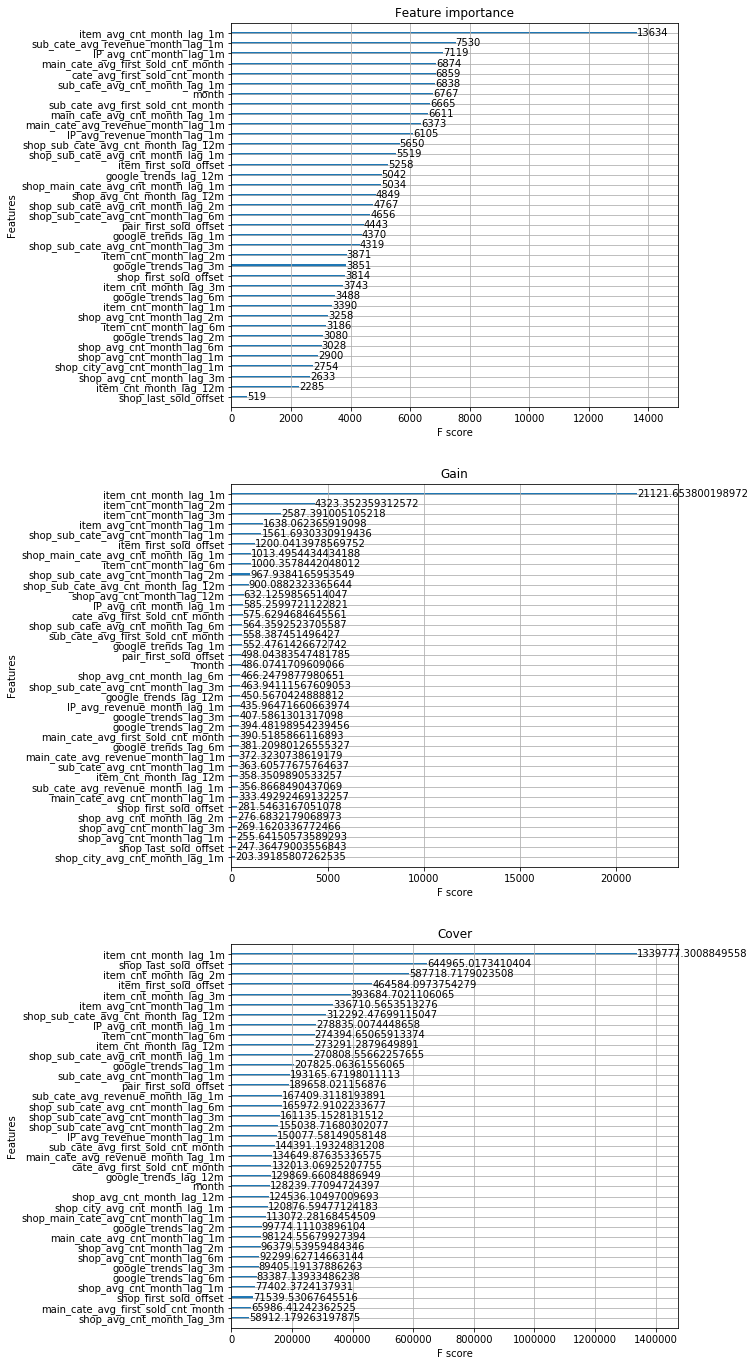

In [76]:
fig = plt.figure(figsize=(8,24))
ax1 = fig.add_subplot(311)
xgb.plot_importance(model,ax=ax1)

ax2 = fig.add_subplot(312)
xgb.plot_importance(model,ax=ax2,importance_type='gain',title='Gain')

ax3 = fig.add_subplot(313)
xgb.plot_importance(model,ax=ax3,importance_type='cover',title='Cover')

### Validation Residue

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'residue')]

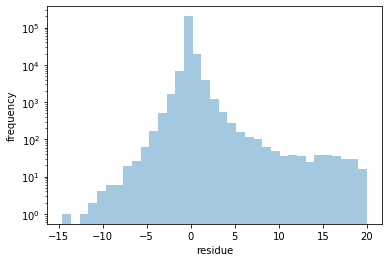

In [77]:
pred_val = model.predict(X_validate)
residue = y_validate-pred_val

plt.figure(figsize=(6,4))
g = sns.distplot(residue,bins=35,kde=False)
g.set(yscale='log')
g.set(xlabel='residue', ylabel='frequency')

### Ouput Submission

In [78]:
pred_test = model.predict(X_test)
output = pd.DataFrame({'item_cnt_month':pred_test})
output.index.name = 'ID'

In [ ]:
output = output.clip(0,20)
output.to_csv('./submission.csv')